<a href="https://colab.research.google.com/github/YuliaCherniakova/YuliaCherniakova/blob/main/GNP_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Предсказание временных рядов

## Введение. Постановка целей и задач.


Задачей данного исследования является построение прогноза величины валового национального продукта США и корреляции между этой величиной и  количеством трудоустроенных на последующий период 1963 - 1967 годов. Построение данного прогноза даст возможность оценит процент прироста/падения величины ВНП по ходу долгосрочного тренда. По итогу данного исследования полученные по прогнозу данные будут сравнены с истинными данными, полученными в данный временной промежуток.

Для этого нам нужно поставить цель:
**Определить характер тренда величины ВНП и получить прогноз на следующие 5 лет.**
Задачи исследования:
- просчитать корреляцию между показателем ВНП и количества трудоустроенных.
- визуализировать разницу между трудоустроенными и нетрудоустроенными гражданами
- объяснить обнаруженные в ходе исследования феномены
- просчитать процент обоих показателей от общего населения Соединенных Штатов в период, данный в датасете. 

Data Source: Longley, J.W. (1967) "An Appraisal of Least Squares Programs for the
    Electronic Comptuer from the Point of View of the User."  Journal of
    the American Statistical Association.  62.319, 819-41.

### Импорт Датафрейма, библиотек, написание функций.

В этом блоке мы импортируем все, что нам нужно для работы: библиотеки, отдельные функции, сам датасет.

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## Здесь импортируем библиотеки и функции 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA #модель ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from prophet import Prophet #модель PROPHET
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.linear_model import LinearRegression #модель линейной регрессии

In [ ]:
## Здесь импортируем данные.
import statsmodels.api as sm
data = sm.datasets.longley.load_pandas()
df = data.data
df['YEAR']= pd.to_datetime(df['YEAR'], format="%Y")

In [ ]:
## Обязательно проверьте, что все выгрузилось корректно.
df.head(16)

,TOTEMP,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
0,60323.0,83.0,234289.0,2356.0,1590.0,107608.0,1947
1,61122.0,88.5,259426.0,2325.0,1456.0,108632.0,1948
2,60171.0,88.2,258054.0,3682.0,1616.0,109773.0,1949
3,61187.0,89.5,284599.0,3351.0,1650.0,110929.0,1950
4,63221.0,96.2,328975.0,2099.0,3099.0,112075.0,1951
5,63639.0,98.1,346999.0,1932.0,3594.0,113270.0,1952
6,64989.0,99.0,365385.0,1870.0,3547.0,115094.0,1953
7,63761.0,100.0,363112.0,3578.0,3350.0,116219.0,1954
8,66019.0,101.2,397469.0,2904.0,3048.0,117388.0,1955
9,67857.0,104.6,419180.0,2822.0,2857.0,118734.0,1956


### Знакомство с данными.

В данном разделе следует ознакомиться с базовыми характеристиками датасета и убедиться в должном формате данных для дальнейшего анализа и постороения прогноза.

In [ ]:
#Диапазон, тип данных, пропущенные значения
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   TOTEMP   16 non-null     float64       
 1   GNPDEFL  16 non-null     float64       
 2   GNP      16 non-null     float64       
 3   UNEMP    16 non-null     float64       
 4   ARMED    16 non-null     float64       
 5   POP      16 non-null     float64       
 6   YEAR     16 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.0 KB


In [ ]:
#Наименование колонн 
df.columns.tolist()

['TOTEMP', 'GNPDEFL', 'GNP', 'UNEMP', 'ARMED', 'POP', 'YEAR']

In [ ]:
#Количество типов данных
df.dtypes.value_counts()

float64           6
datetime64[ns]    1
dtype: int64

In [ ]:
#Базовые статистические показатели
df.describe().round(decimals = 2)

,TOTEMP,GNPDEFL,GNP,UNEMP,ARMED,POP
count,16.00,16.00,16.00,16.00,16.00,16.0
mean,65317.00,101.68,387698.44,3193.31,2606.69,117424.0
std,3511.97,10.79,99394.94,934.46,695.92,6956.1
min,60171.00,83.00,234289.00,1870.00,1456.00,107608.0
25%,62712.50,94.52,317881.00,2348.25,2298.00,111788.5
50%,65504.00,100.60,381427.00,3143.50,2717.50,116803.5
75%,68290.50,111.25,454085.50,3842.50,3060.75,122304.0
max,70551.00,116.90,554894.00,4806.00,3594.00,130081.0


## Предобработка данных

### Обработка пропусков

В процессе обработки датасет следует проверить на наличие пропусков.

In [ ]:
missing_df=df.isnull()
missing_df.head(16)

,TOTEMP,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False


In [ ]:
df.isnull().sum()

TOTEMP     0
GNPDEFL    0
GNP        0
UNEMP      0
ARMED      0
POP        0
YEAR       0
dtype: int64

Как видно по итогам обработки, датасет не содержит пропущенных значений.

### Фильтрация данных

Для дальнейшей работы с датасетом следует оставить только те данные, которые понадобятся для дальнейшего анализа. Поэтому целесообразно будет опустить столбцы с значениями дефлятора ВНП и количества граждан, трудоустроенных в вооруженных силах.

In [ ]:
df1 = df.drop(columns = ['GNPDEFL','ARMED'], axis = 1)
df1.head()

,TOTEMP,GNP,UNEMP,POP,YEAR
0,60323.0,234289.0,2356.0,107608.0,1947-01-01
1,61122.0,259426.0,2325.0,108632.0,1948-01-01
2,60171.0,258054.0,3682.0,109773.0,1949-01-01
3,61187.0,284599.0,3351.0,110929.0,1950-01-01
4,63221.0,328975.0,2099.0,112075.0,1951-01-01


 ### Вывод по этапу.


Была сформулирована цель данного исследования, разработаны задачи для ее выполнения. Данный датасет был обработан для дальнейшей работы(изменен тип данных, проведена фильтрация на наличие пропущенных данных и ненужных для дальнейшего анализа данных. 

## EDA или разведочный анализ данных.

In [ ]:
#Установка индекса
df1.set_index('YEAR', inplace=True)
df1.head(7)

,TOTEMP,GNP,UNEMP,POP
YEAR,,,,
1947-01-01,60323.0,234289.0,2356.0,107608.0
1948-01-01,61122.0,259426.0,2325.0,108632.0
1949-01-01,60171.0,258054.0,3682.0,109773.0
1950-01-01,61187.0,284599.0,3351.0,110929.0
1951-01-01,63221.0,328975.0,2099.0,112075.0
1952-01-01,63639.0,346999.0,1932.0,113270.0
1953-01-01,64989.0,365385.0,1870.0,115094.0


Базовой визуализацией данного исследования является разность между количеством трудоустроенными и нетрудоустроенными гражданми США в период с 1947 по 1962 гг. Положительный тренд в количестве трудоустроенных и нетрудоустроенных граждан напрямую связан с увеличением населения в целом.

Так же видна обратная зависимость в скачках на обоих диаграммах: при наличии пика в количестве нетрудоустоенных, например, в 1949 году, количество трудоустроенных снижается. 

1949 - Конгресс принял закон о балансе интересов менеджмента и профсоюзов;

1953 - к власти пришел президент Эйзенхауэр

1958 - рецессия

1962 - концепция "Новые Рубежи" Дж.Кеннеди

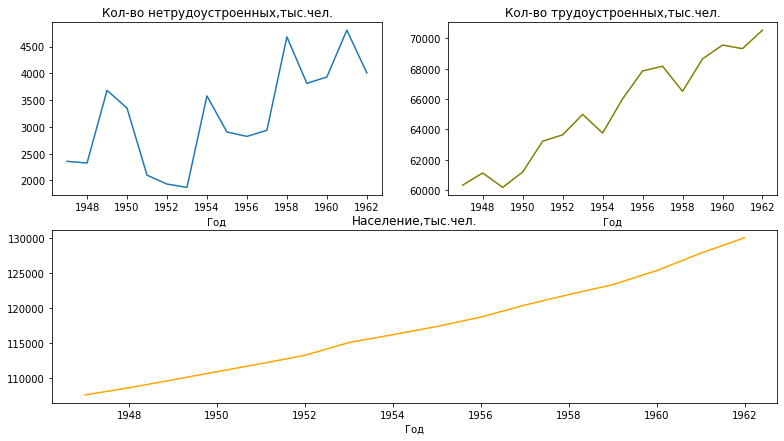

In [ ]:
x1title='Кол-во нетрудоустроенных,тыс.чел.'
x1label='Год'
y1label=''

x2title='Кол-во трудоустроенных,тыс.чел.'
x2label='Год'
y2label=''

x3title='Население,тыс.чел.'
x3label='Год'
y3label=''

plt.figure(figsize=(13,7))
plt.subplot(2,2,1)
df1['UNEMP'].plot(title=x1title, xlabel=x1label, ylabel=y1label)

plt.subplot(2,2,2)
df1['TOTEMP'].plot(title=x2title, xlabel=x2label, ylabel=y2label, color='olive')

plt.subplot(2,2,(3,4))
df1['POP'].plot(title=x3title, xlabel=x3label, ylabel=y3label, color='orange')


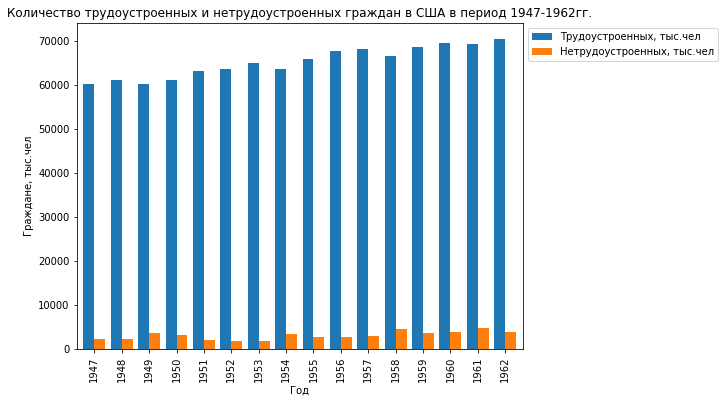

In [ ]:
xtitle='Количество трудоустроенных и нетрудоустроенных граждан в США в период 1947-1962гг.'
xlabel='Год'
ylabel='Граждане, тыс.чел'
df1[['TOTEMP','UNEMP']].plot.bar(figsize=(8,6), width=0.8, xlabel=xlabel, ylabel=ylabel, title=xtitle)
plt.legend(['Трудоустроенных, тыс.чел', 'Нетрудоустроенных, тыс.чел'], bbox_to_anchor=(1,1))

При относительно стабильном долгосрочном тренде роста населения США, период 50-60гг. сопровождался бурным экономическим ростом по причине научно-технической революции.

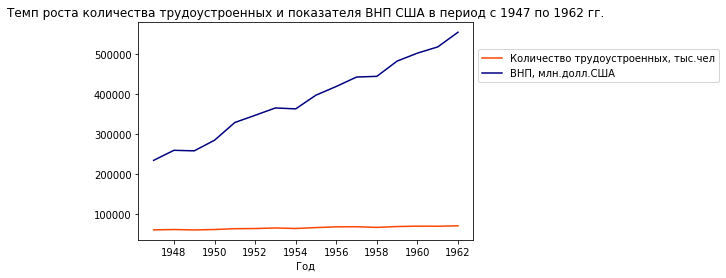

In [ ]:
xtitle='Темп роста количества трудоустроенных и показателя ВНП США в период с 1947 по 1962 гг.'
xlabel='Год'
ylabel=' '

colors=['orangered','navy']
df1[['TOTEMP','GNP']].plot(title=xtitle, xlabel=xlabel, ylabel=ylabel, color=colors)
plt.legend(['Количество трудоустроенных, тыс.чел', 'ВНП, млн.долл.США'], bbox_to_anchor=(1,0.9))

In [ ]:
dfc=df1.copy()
dfc['EMP_PERCENT'] = dfc['TOTEMP']/dfc['POP'] *100    #нахождение доли трудоустроенных и нетрудоустроенных в процентах для последующей визуализации
dfc['UNEMP_PERCENT'] = dfc['UNEMP']/dfc['POP'] *100
dfc['EMP_PERCENT'] = dfc['EMP_PERCENT'].round(decimals = 2)
dfc['UNEMP_PERCENT'] = dfc['UNEMP_PERCENT'].round(decimals = 2)
dfc.head(16)

,TOTEMP,GNP,UNEMP,POP,EMP_PERCENT,UNEMP_PERCENT
YEAR,,,,,,
1947,60323.0,234289.0,2356.0,107608.0,56.06,2.19
1948,61122.0,259426.0,2325.0,108632.0,56.27,2.14
1949,60171.0,258054.0,3682.0,109773.0,54.81,3.35
1950,61187.0,284599.0,3351.0,110929.0,55.16,3.02
1951,63221.0,328975.0,2099.0,112075.0,56.41,1.87
1952,63639.0,346999.0,1932.0,113270.0,56.18,1.71
1953,64989.0,365385.0,1870.0,115094.0,56.47,1.62
1954,63761.0,363112.0,3578.0,116219.0,54.86,3.08
1955,66019.0,397469.0,2904.0,117388.0,56.24,2.47


In [ ]:
df1me = df1['EMP_PERCENT'].mean()  #нахождение среднего значения доли трудоустроенных и нетрудоустроенных для визуализации
df1mu = df1['UNEMP_PERCENT'].mean()
print(df1me, df1mu)

55.6475 2.6987499999999995


Усредненные данные за 16 лет показывают, что в общей доле населения в среднем 55% жителей являются трудоустроенными и лишь почти 3% являются нетрудоустроенными на постоянной основе.

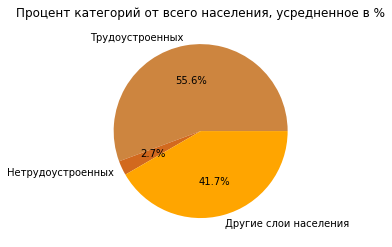

In [ ]:
my_data = [df1me, df1mu, 100-(df1me+df1mu)]
my_labels = 'Трудоустроенных', 'Нетрудоустроенных', 'Другие слои населения'
my_colors = ["peru", "chocolate", "orange"]
plt.pie(my_data, labels=my_labels, autopct='%1.1f%%', colors=my_colors)
plt.title('Процент категорий от всего населения, усредненное в %')
plt.show()

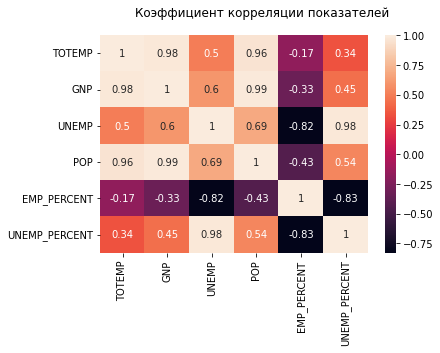

In [ ]:
data = dfc.corr()   #Визуализация корреляции между столбцами
sns.heatmap(data, annot=True)
plt.suptitle('Коэффициент корреляции показателей')
plt.show()

Для построения модели прогнозирования количества трудоустроенных в последующий период следует найти корреляцию между ВНП и количеством трудустроенных и утвердить гипотезу: какова зависимость ВНП от количества трудоустроенных?

In [ ]:
a = np.corrcoef(df1['GNP'], df1['TOTEMP'])   #Нахождение корреляции между показателем ВНП и количеством трудоустроенных
print(a)

[[1.         0.98355161]
 [0.98355161 1.        ]]


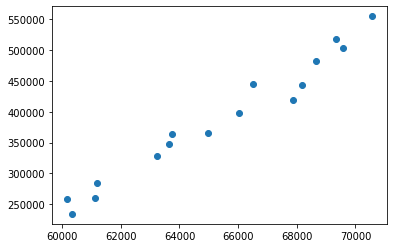

In [ ]:
plt.scatter(df1['TOTEMP'], df1['GNP'])

Text(0.5, 1.0, 'Корреляция между показателями ВНП и количеством трудоустроенных')

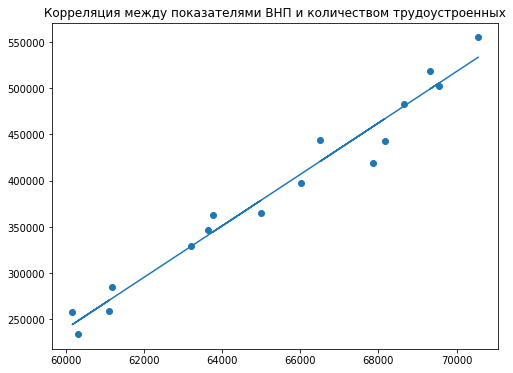

In [ ]:
f = plt.figure()   #визуализация корреляции между показателем ВНП и количеством трудоустроенных
f.set_figwidth(8)
f.set_figheight(6)
plt.scatter(df1['TOTEMP'], df1['GNP'])
m, b = np.polyfit(df1['TOTEMP'], df1['GNP'], 1)
plt.plot(df1['TOTEMP'], m*df1['TOTEMP']+b)
plt.title('Корреляция между показателями ВНП и количеством трудоустроенных')

Прямая линейная зависимость.

## Построение моделей, анализ результатов.

Учитывая размер датасета(16 строк), наиболее предпочтительным диапазоном прогноза будет являться период в 5 лет, так как более длинный срок прогноза может оказаться искаженным за счет небольшого размера датасета. 

###ARIMA

In [ ]:
dfa = df1.drop(columns = ['TOTEMP','UNEMP','POP'], axis = 1) #обработка датасета до формата временного ряда
dfa.head(16)

,GNP
YEAR,
1947-01-01,234289.0
1948-01-01,259426.0
1949-01-01,258054.0
1950-01-01,284599.0
1951-01-01,328975.0
1952-01-01,346999.0
1953-01-01,365385.0
1954-01-01,363112.0
1955-01-01,397469.0


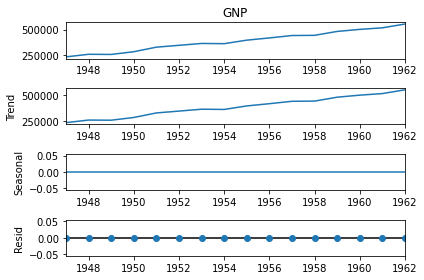

In [ ]:
result=seasonal_decompose(dfa['GNP'], model='additive') #выполнение сезонной декомпозиции в целях выявления сезонности
result.plot()  

import warnings
warnings.filterwarnings("ignore")

In [ ]:
auto_arima(dfa['GNP'], m=5, seasonal=True).summary() # прогнозируем временной ряд и выводим суммарный результат. сезонность 10 месяцев установлена экспертным методом, путём анализа графиков

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   16
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -164.060
Date:                Thu, 09 Feb 2023   AIC                            332.119
Time:                        12:20:04   BIC                            333.535
Sample:                    01-01-1947   HQIC                           332.104
                         - 01-01-1962                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.137e+04   3610.876      5.919      0.000    1.43e+04    2.85e+04
sigma2      1.852e+08   8.68e+07      2.133      0.033     1.5e+07    3.55e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.75   Jarque-Bera (JB):                 0.49
Prob(Q):                              0.19   Prob(JB):                         0.78
Heteroskedasticity (H):               0.85   Skew:                            -0.26
Prob(H) (two-sided):                  0.87   Kurtosis:                         2.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
train=dfa[:11]   #разделение датасета на тестовую и тренировочную части и последующее обучение модели
test=dfa[11:]

model=ARIMA(train['GNP'], order=(0,1,0), seasonal_order=(0,0,1,12))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                GNP   No. Observations:                   11
Model:             ARIMA(0, 1, 0)x(0, 0, [1], 12)   Log Likelihood                -115.421
Date:                            Thu, 09 Feb 2023   AIC                            234.842
Time:                                    12:20:06   BIC                            235.447
Sample:                                01-01-1947   HQIC                           234.178
                                     - 01-01-1957                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       1.0000      0.644      1.554      0.120      -0.262       2.262
sigma2      2.842e+08   2.26e-09   1.26e+17      0.000    2.84e+08    2.84e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):                 0.23
Prob(Q):                              0.44   Prob(JB):                         0.89
Heteroskedasticity (H):               1.65   Skew:                            -0.30
Prob(H) (two-sided):                  0.69   Kurtosis:                         2.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [ ]:
xstart=len(train)  #вывод предсказанных по тестовой части значений
xend=len(train)+len(test)-1

prediction=results.predict(start=xstart, end=xend, dynamic=False).rename('ARIMA(0, 1, 0)x(0, 0, 1, 12)')
 

for i in range(len(prediction)):
          print(f"predicted={prediction[i]:<11.10}, expected={test['GNP'][i]}")

predicted=442769.0   , expected=444546.0
predicted=559707.7879, expected=482704.0
predicted=572276.2879, expected=502601.0
predicted=571590.2879, expected=518173.0
predicted=584862.7879, expected=554894.0


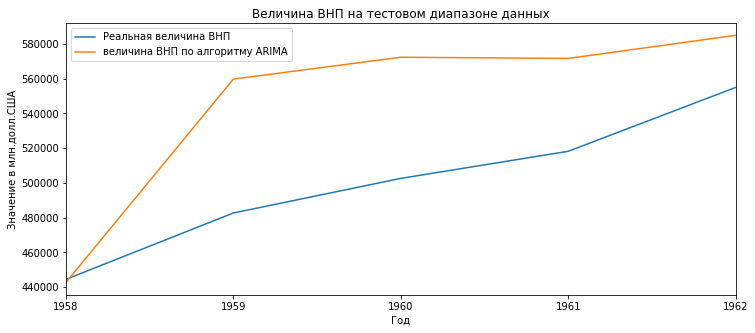

In [ ]:
xtitle='Величина ВНП на тестовом диапазоне данных'
xlabel='Год'
ylabel='Значение в млн.долл.США'
a=test['GNP'].plot(figsize=(12,5), legend=True, title=xtitle)
prediction.plot(legend=True)

a.autoscale(axis='x', tight=True)
a.set(xlabel=xlabel, ylabel=ylabel)
a.legend(['Реальная величина ВНП', 'величина ВНП по алгоритму ARIMA'], loc='upper left', bbox_to_anchor=(0,1))

In [ ]:
error1=mean_squared_error(test['GNP'], prediction) #
error2=rmse(test['GNP'], prediction)
print(f'ARIMA(0, 1, 0)x(0, 0, 1, 12) MSE Error:{error1}')
print(f'ARIMA(0, 1, 0)x(0, 0, 1, 12) RMSE Error:{error2}')

ARIMA(0, 1, 0)x(0, 0, 1, 12) MSE Error:2907784346.595996
ARIMA(0, 1, 0)x(0, 0, 1, 12) RMSE Error:53923.87547827025


In [ ]:
auto_arima(dfa['GNP'],seasonal=True,m=5).summary()  #построение прогноза и последующий вывод предсказанных на указанный период значений

model=ARIMA(dfa['GNP'], order=(0,1,0), seasonal_order=(0,1,0,12))
results=model.fit()

fcast=results.predict(len(dfa)-1, len(dfa)+4,typ='levels').rename('ARIMA(0, 1, 0)x(0, 1, 0, 12)')
fcast.head()

1962-01-01    544718.0
1963-01-01    599270.0
1964-01-01    617294.0
1965-01-01    635680.0
1966-01-01    633407.0
Freq: AS-JAN, Name: ARIMA(0, 1, 0)x(0, 1, 0, 12), dtype: float64

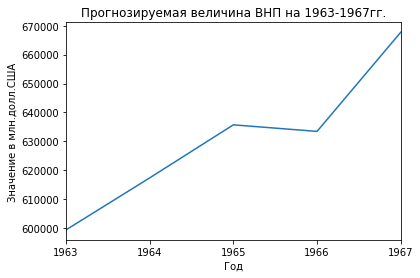

In [ ]:
xtitle='Прогнозируемая величина ВНП на 1963-1967гг.'
xlabel='Год'
ylabel='Значение в млн.долл.США'

fcast.plot(xlabel=xlabel, ylabel=ylabel, title=xtitle)

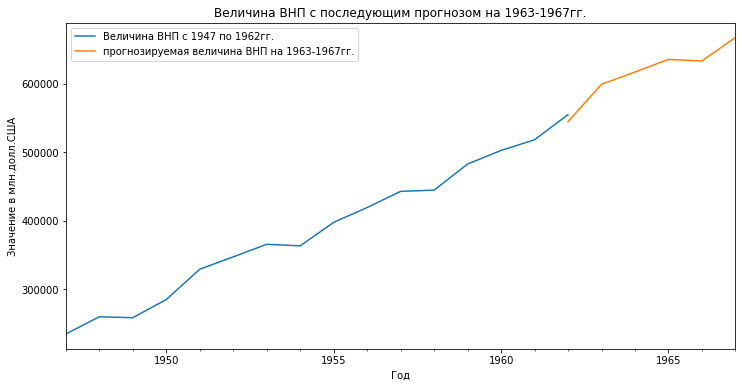

In [ ]:
xtitle='Величина ВНП с последующим прогнозом на 1963-1967гг.'
xlabel='Год'
ylabel='Значение в млн.долл.США'

a=dfa['GNP'].plot( figsize=(12,6), legend=True, title=xtitle)
fcast.plot(legend=True)
a.autoscale(axis='x', tight=True)
a.set(xlabel=xlabel, ylabel=ylabel)
a.legend(['Величина ВНП с 1947 по 1962гг.', 'прогнозируемая величина ВНП на 1963-1967гг.'])

###PROPHET

In [ ]:
dfp = df.drop(columns = ['GNPDEFL','ARMED','TOTEMP','UNEMP','POP'], axis = 1) #формирование датасета, который понадобится для использования данного алгоритма
dfp.rename(columns={'YEAR':'ds', 'GNP':'y'}, inplace=True)
dfp.head(16)

,y,ds
0,234289.0,1947-01-01
1,259426.0,1948-01-01
2,258054.0,1949-01-01
3,284599.0,1950-01-01
4,328975.0,1951-01-01
5,346999.0,1952-01-01
6,365385.0,1953-01-01
7,363112.0,1954-01-01
8,397469.0,1955-01-01
9,419180.0,1956-01-01


In [ ]:
m = Prophet()  #обучение модели
m.fit(dfp)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3l49km59/pd7n7n4t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3l49km59/vb56vq0r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19955', 'data', 'file=/tmp/tmp3l49km59/pd7n7n4t.json', 'init=/tmp/tmp3l49km59/vb56vq0r.json', 'output', 'file=/tmp/tmp3l49km59/prophet_modelspy3ls4t/prophet_model-20230209122029.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:20:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:20:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

In [ ]:
future = m.make_future_dataframe(periods=5, freq='as-jan') #создание датафрема для будущих предсказанных значений
future.tail()

,ds
16,1963-01-01
17,1964-01-01
18,1965-01-01
19,1966-01-01
20,1967-01-01


In [ ]:
forecast = m.predict(future) #вывод предсказанных значений
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail().round(decimals=3)

,ds,yhat,yhat_lower,yhat_upper
16,1963-01-01,565866.797,555250.795,577171.133
17,1964-01-01,592381.358,581176.467,604589.284
18,1965-01-01,603618.239,592564.937,614453.509
19,1966-01-01,625425.037,614677.817,635759.052
20,1967-01-01,649590.070,638673.101,660319.140


In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly #визуализация предсказанных значений

plot_plotly(m, forecast)

In [ ]:
plot_components_plotly(m, forecast)

###LINEAR

In [ ]:
dfl = df.drop(columns = ['GNPDEFL','ARMED', 'POP', 'UNEMP', 'YEAR'], axis = 1)   #подготовка данных для прогнозирования методом линейной регрессии
x = dfl['GNP'].to_numpy().reshape((-1, 1))  #изменение датафреймов для правильного функционирования модели
y = dfl['TOTEMP'].to_numpy()

In [ ]:
print(x)
print(y)

[[234289.]
 [259426.]
 [258054.]
 [284599.]
 [328975.]
 [346999.]
 [365385.]
 [363112.]
 [397469.]
 [419180.]
 [442769.]
 [444546.]
 [482704.]
 [502601.]
 [518173.]
 [554894.]]
[60323. 61122. 60171. 61187. 63221. 63639. 64989. 63761. 66019. 67857.
 68169. 66513. 68655. 69564. 69331. 70551.]


In [ ]:
model = LinearRegression()  #обучение модели
model.fit(x, y)

LinearRegression()

In [ ]:
r_sq = model.score(x, y)  #вывод статистических показателей
print('коэффициент детерминации:', r_sq)
print('пересечение:', model.intercept_)
print('наклон:', model.coef_)

коэффициент детерминации: 0.9673737718541237
пересечение: 51843.58978188413
наклон: [0.03475229]


In [ ]:
y_pred = model.predict(x)   #вывод прогнозируемых значений
print('прогнозируемый ответ:', y_pred, sep='\n')

прогнозируемый ответ:
[59985.6700723  60859.23849531 60811.55834747 61734.05800093
 63276.2258149  63902.60116822 64541.55685209 64462.56488704
 65656.54946394 66411.05652652 67230.82839789 67292.58322495
 68618.66127266 69310.1276733  69851.29040088 71127.42940162]


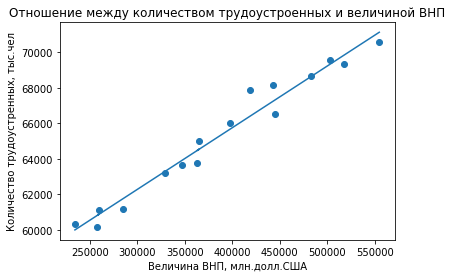

In [ ]:
plt.scatter(x, y)  #визуализация линейной регрессии
plt.plot(x, model.predict(x))
plt.title("Отношение между количеством трудоустроенных и величиной ВНП")
plt.xlabel("Величина ВНП, млн.долл.США")
plt.ylabel("Количество трудоустренных, тыс.чел")
plt.show()

###Cравненительный анализ


In [ ]:
#Источник данных: National Bureau of Economic Research
dfr = pd.DataFrame({'YEARACTUAL': ['1963', '1964', '1965', '1966', '1967'], 'GNPACTUAL': [605863.0, 645107.0, 710644.0, 768265.0, 811023.0]})  #создание датафрейма с реальными значениями для сравения с прогнозами
dfr['YEARACTUAL']= pd.to_datetime(dfr['YEARACTUAL'], format="%Y")
dfr.set_index('YEARACTUAL', inplace=True)
dfr.asfreq(freq='AS-JAN')
dfr.head()

,GNPACTUAL
YEARACTUAL,
1963-01-01,605863.0
1964-01-01,645107.0
1965-01-01,710644.0
1966-01-01,768265.0
1967-01-01,811023.0


In [ ]:
b = forecast.drop(columns =['trend',	'yhat_lower',	'yhat_upper',	'trend_lower',	'trend_upper',	'additive_terms',	'additive_terms_lower',	'additive_terms_upper',	'yearly',	'yearly_lower',	'yearly_upper',	'multiplicative_terms',	'multiplicative_terms_lower',	'multiplicative_terms_upper'], axis=1)
b.set_index('ds', inplace=True)     #создание датафрейма из предсказанных PROPHET'ом значений и ограничение его пятью строками с нужным периодом 1963-1967гг.
b.rename(columns={ 'yhat':'GNPPROPHET'}, inplace=True)
b1 = b.iloc[16:]
b1.head()

,GNPPROPHET
ds,
1963-01-01,565866.796670
1964-01-01,592381.357872
1965-01-01,603618.239385
1966-01-01,625425.036744
1967-01-01,649590.069755


In [ ]:
dfu = dfr.join(b1)  #соединение трех датафреймов(два прогноза и один с реальными данными) в один для будущего сравнения
dfu = dfu.join(fcast)
dfu.rename(columns={'YEARACTUAL':'YEAR', 'GNP':'GNPPROPHET', 'ARIMA(0, 1, 0)x(0, 1, 0, 12)':'GNPARIMA'}, inplace=True)
dfu.head()

,GNPACTUAL,GNPPROPHET,GNPARIMA
YEARACTUAL,,,
1963-01-01,605863.0,565866.796670,599270.0
1964-01-01,645107.0,592381.357872,617294.0
1965-01-01,710644.0,603618.239385,635680.0
1966-01-01,768265.0,625425.036744,633407.0
1967-01-01,811023.0,649590.069755,667764.0


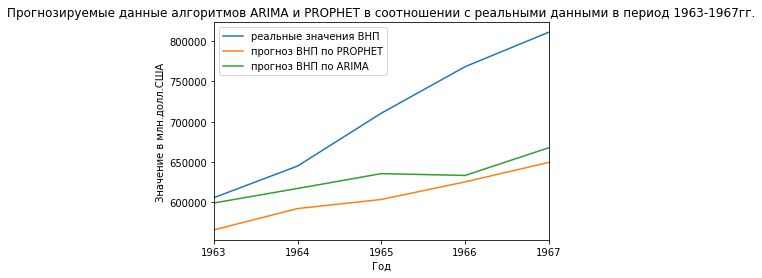

In [ ]:
xtitle='Прогнозируемые данные алгоритмов ARIMA и PROPHET в соотношении с реальными данными в период 1963-1967гг.'  #визуализация сравнения
xlabel='Год'
ylabel='Значение в млн.долл.США'
dfu.plot(xlabel=xlabel, ylabel=ylabel, title=xtitle, legend=True)
plt.legend(['реальные значения ВНП', 'прогноз ВНП по PROPHET', 'прогноз ВНП по ARIMA'])

Значения моделей прогноза приблизительно равны друг другу на протяжении всего диапазона прогноза, однако реально представленные данные, которые в первой половине диапазона относительно близки к прогнозируемым значениям, во второй половине диапазона оказались значительно больше, чем предполагалось.
Возможно, это связано с чрезмерно-экстенсивным ростом экономики США в период экономических реформ, которые предшествовали нефтяному кризису 1973 года.


##Выводы

Был обнаружен положительный тренд в росте ВНП США в период с 1947 по 1962гг. На основе имеющихся данных и проведенного разведочного анализа был создан прогноз дальнейшего развития величины ВНП на последующие 5 лет при помощи моделей ARIMA и PROPHET.

Так же был проведен анализ при помощи модели линейной регрессии на предмет корреляции между показателями ВНП и количеством трудящихся, который показал практически прямую зависимость между двуся данными показателями.

По заверешении создания моделей прогноза был проведен сравнительный анализ полученных значений и реальных представленных данных. Значения моделей прогноза были приблизительно равны друг другу на протяжении всего диапазона прогноза, однако реально представленные данные, которые в первой половине диапазона были относительно близки к прогнозируемым значениям, во второй половине диапазона оказались значительно больше, чем предполагалось.